The k-modes algorithm uses a simple matching dissimilarity measure
to deal with categorical objects, replaces the means of clusters with modes, and uses a frequency-based method to
update modes in the clustering process to minimize the clustering cost function. With these extensions the k-modes
algorithm enables the clustering of categorical data in a fashion similar to k-means

In [1]:
'''Load Packages'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist
from kmodes.kmodes import KModes
from pandas_profiling import ProfileReport

In [34]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
new_df = pd.read_csv('newdata.csv')

In [35]:
carmax_df['job_assign'] = new_df['job_assign']
carmax_df['customer_income'] = new_df['new_income']
carmax_df['customer_age'] = new_df['new_ages']
carmax_df['purchase_price'] = new_df['purchase_price']

In [36]:
carmax_df.head()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class,made_in,job_assign,purchase_price
0,DODGE,CHARGER,2012,15001.0,20000.0,1,1,21 - 30,40001 - 60000,U,0,8.0,?,0,1,Twenties,sedan,UNITED STATES,"Life, Physical, and Social Science Technicians...",15001 - 20000
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties,truck,UNITED STATES,"Entertainers and Performers, Sports and Relate...",15001 - 20000
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties,sedan,GERMANY,Farm Labor Contractors,25001 - 30000
3,LEXUS,GS 300,2003,10001.0,15000.0,0,1,21 - 30,20001 - 40000,M,0,8.0,?,0,0,Twenties,sedan,JAPAN,Painting Workers,10001 - 15000
4,CHEVROLET,CRUZE,2012,15001.0,20000.0,1,1,31 - 40,120001 - 140000,M,1,5.0,?,1,1,Thirties,sedan,UNITED STATES,Natural Sciences Managers,15001 - 20000


In [37]:
cluster_df = carmax_df.copy().drop(['customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used','purchase_price_LB',
                             'purchase_price_UB','purchase_class','job_assign','purchase_vehicle_year','subsequent_purchases'], axis=1)

In [38]:
cluster_df['purchase_class'] = carmax_df['purchase_class']
cluster_df

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,purchase_class
0,DODGE,CHARGER,1,1,40001 - 60000,U,Twenties,UNITED STATES,15001 - 20000,sedan
1,FORD,F150,0,0,0 - 20000,F,Fifties,UNITED STATES,15001 - 20000,truck
2,BMW,328,1,1,60001 - 80000,F,Forties,GERMANY,25001 - 30000,sedan
3,LEXUS,GS 300,0,1,20001 - 40000,M,Twenties,JAPAN,10001 - 15000,sedan
4,CHEVROLET,CRUZE,1,1,120001 - 140000,M,Thirties,UNITED STATES,15001 - 20000,sedan
...,...,...,...,...,...,...,...,...,...,...
355869,JEEP,LIBERTY,0,1,20001 - 40000,F,Twenties,UNITED STATES,15001 - 20000,wagon
355870,CHEVROLET,SONIC,1,0,20001 - 40000,U,Seventies,UNITED STATES,10001 - 15000,sedan
355871,KIA,SORENTO,1,1,20001 - 40000,F,Sixties,SOUTH KOREA,15001 - 20000,suv
355872,NISSAN,350Z,0,1,40001 - 60000,M,Twenties,JAPAN,10001 - 15000,coupe


In [39]:
sedan = cluster_df[cluster_df.purchase_class=='sedan'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
truck = cluster_df[cluster_df.purchase_class=='truck'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
suv = cluster_df[cluster_df.purchase_class=='suv'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
wagon = cluster_df[cluster_df.purchase_class=='wagon'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
van = cluster_df[cluster_df.purchase_class=='van'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
coupe = cluster_df[cluster_df.purchase_class=='coupe'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
convertible = cluster_df[cluster_df.purchase_class=='convertible'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)

vehicle_classes = [sedan,truck,suv,wagon,van,coupe,convertible]

In [40]:
# vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
# index = 0

# for group in vehicle_classes:
#     K = range(1,10) 
#     inertias = []
#     mapping2 = {} 
    
#     for k in K: 
#         #Building and fitting the model 
#         kmodesModel = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
#         kmodesModel.fit(group.values)     
       
#         inertias.append(kmodesModel.cost_) 
  
#         mapping2[k] = kmodesModel.cost_ 
    
#     print(vehicle_classes_name[index])
#     index += 1
    
#     for key,val in mapping2.items(): 
#         print(str(key)+' : '+str(val)) 
    
#     plt.plot(K, inertias, 'bx-') 
#     plt.xlabel('Values of K') 
#     plt.ylabel('Inertia') 
#     plt.title('The Elbow Method using Inertia') 
#     plt.show()   

In [41]:
#k_values = [7,7,6,6,6,6,6]
ref = {}
vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
index = 0

for group in vehicle_classes:  
    k_modes = KModes(n_clusters=5, init='Huang', n_init=5, verbose=0,random_state = 2013)
    ref[vehicle_classes_name[index]] = k_modes.fit(group.values)    
    labels = k_modes.labels_
    group["cluster_label"] = labels
    index += 1


In [10]:
# k_modes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=0,random_state = 2013)
    
# #k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan",random_state = 2013)
    
# k_modes.fit(suv.values)
# labels = k_modes.labels_
# suv["cluster_label"] = labels

In [11]:
# test = suv.groupby(['cluster_label','purchase_model']).count().reset_index()
# test = test.sort_values(by=['cluster_label','purchase_price'],ascending=[True,False])
# test = test.groupby('cluster_label').head(10)[['cluster_label','purchase_model','purchase_price']]
# test.pivot(index = 'purchase_model',columns='cluster_label',values='purchase_price').fillna(0).style.highlight_max(color = 'green').format(int)

In [42]:
test = suv.groupby(['cluster_label','made_in']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'made_in',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4
made_in,,,,,
GERMANY,1020,1068,2852,348,430
JAPAN,19931,901,1264,12738,1247
SOUTH KOREA,2238,1063,425,625,1059
SWEDEN,213,135,102,62,106
UNITED KINGDOM,254,395,160,109,163
UNITED STATES,2493,25941,974,0,13054


In [56]:
sedan.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0]).to_excel('sedanCluster.xlsx')

In [44]:
truck.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,TOYOTA,TACOMA,1,1,40001 - 60000,M,Thirties,JAPAN,20001 - 25000
1,CHEVROLET,SILVERADO 1500,0,1,40001 - 60000,M,Forties,UNITED STATES,20001 - 25000
2,FORD,F150,0,1,60001 - 80000,M,Fifties,UNITED STATES,20001 - 25000
3,DODGE,RAM 1500,0,1,20001 - 40000,M,Twenties,UNITED STATES,10001 - 15000
4,FORD,F150,0,0,40001 - 60000,M,Forties,UNITED STATES,15001 - 20000


In [45]:
suv.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,TOYOTA,RAV4,0,1,40001 - 60000,F,Forties,JAPAN,15001 - 20000
1,FORD,ESCAPE,1,1,40001 - 60000,M,Forties,UNITED STATES,15001 - 20000
2,BMW,X5,1,0,60001 - 80000,F,Forties,GERMANY,30001 - 35000
3,NISSAN,ROGUE,1,1,40001 - 60000,M,Fifties,JAPAN,15001 - 20000
4,FORD,EDGE,0,1,20001 - 40000,F,Thirties,UNITED STATES,20001 - 25000


In [46]:
wagon.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,MINI,COOPER,1,1,40001 - 60000,M,Twenties,UNITED KINGDOM,15001 - 20000
1,JEEP,LIBERTY,1,1,40001 - 60000,F,Forties,UNITED STATES,15001 - 20000
2,TOYOTA,PRIUS,1,1,20001 - 40000,M,Thirties,JAPAN,10001 - 15000
3,TOYOTA,PRIUS,0,1,20001 - 40000,M,Forties,JAPAN,15001 - 20000
4,JEEP,LIBERTY,0,1,20001 - 40000,F,Twenties,UNITED STATES,10001 - 15000


In [47]:
van.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,DODGE,GRAND CARAVAN,1,1,40001 - 60000,M,Thirties,UNITED STATES,15001 - 20000
1,CHRYSLER,TOWN AND COUNTRY,0,1,40001 - 60000,F,Thirties,UNITED STATES,20001 - 25000
2,MAZDA,MAZDA5,0,1,20001 - 40000,F,Forties,JAPAN,15001 - 20000
3,TOYOTA,SIENNA,0,1,20001 - 40000,M,Forties,JAPAN,10001 - 15000
4,HONDA,ODYSSEY,1,1,60001 - 80000,M,Thirties,JAPAN,20001 - 25000


In [48]:
coupe.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,HONDA,CIVIC,0,1,40001 - 60000,M,Forties,JAPAN,10001 - 15000
1,HONDA,CIVIC,0,1,40001 - 60000,F,Twenties,JAPAN,15001 - 20000
2,MERCEDES-BENZ,C300,1,1,80001 - 100000,M,Forties,GERMANY,20001 - 25000
3,HONDA,ACCORD,0,1,20001 - 40000,M,Thirties,JAPAN,15001 - 20000
4,MERCEDES-BENZ,C300,0,1,40001 - 60000,F,Thirties,GERMANY,25001 - 30000


In [49]:
convertible.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,
0,MERCEDES-BENZ,E350,0,1,20001 - 40000,M,Thirties,GERMANY,30001 - 35000
1,JEEP,WRANGLER,1,1,40001 - 60000,M,Forties,UNITED STATES,20001 - 25000
2,FORD,MUSTANG,0,1,20001 - 40000,M,Twenties,UNITED STATES,15001 - 20000
3,CHEVROLET,CAMARO,0,1,40001 - 60000,M,Twenties,UNITED STATES,25001 - 30000
4,VOLKSWAGEN,BEETLE,1,1,40001 - 60000,F,Fifties,GERMANY,10001 - 15000


In [21]:
truck[truck.cluster_label == 1]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,cluster_label
1,NISSAN,FRONTIER,0,1,20001 - 40000,M,Twenties,JAPAN,20001 - 25000,1
4,NISSAN,FRONTIER,0,1,40001 - 60000,F,Twenties,JAPAN,20001 - 25000,1
6,DODGE,RAM 1500,1,1,40001 - 60000,M,Fifties,UNITED STATES,10001 - 15000,1
8,FORD,RANGER,0,1,20001 - 40000,M,Twenties,UNITED STATES,10001 - 15000,1
9,DODGE,RAM 1500,0,1,200001+,M,Fifties,UNITED STATES,15001 - 20000,1
...,...,...,...,...,...,...,...,...,...,...
28732,DODGE,RAM 2500,0,1,20001 - 40000,M,Sixties,UNITED STATES,15001 - 20000,1
28733,GMC,SIERRA 1500,0,1,40001 - 60000,M,Twenties,UNITED STATES,10001 - 15000,1
28737,DODGE,RAM 1500,1,1,40001 - 60000,F,Twenties,UNITED STATES,20001 - 25000,1
28742,DODGE,RAM 1500,0,1,40001 - 60000,M,Twenties,UNITED STATES,15001 - 20000,1


In [22]:
cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [23]:
suv[suv.cluster_label == 2]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,AgeBin,made_in,purchase_price,cluster_label
2,DODGE,JOURNEY,1,1,20001 - 40000,U,Thirties,UNITED STATES,15001 - 20000,2
9,MERCURY,MARINER,1,1,60001 - 80000,F,Fifties,UNITED STATES,15001 - 20000,2
13,JEEP,COMPASS,1,1,20001 - 40000,F,Twenties,UNITED STATES,15001 - 20000,2
17,LINCOLN,MKX,1,1,140001 - 160000,F,Fifties,UNITED STATES,25001 - 30000,2
30,DODGE,DURANGO,1,1,0 - 20000,F,Thirties,UNITED STATES,15001 - 20000,2
...,...,...,...,...,...,...,...,...,...,...
91330,CHEVROLET,TRAVERSE,1,1,60001 - 80000,F,Thirties,UNITED STATES,20001 - 25000,2
91344,FORD,ESCAPE,1,1,0 - 20000,F,Twenties,UNITED STATES,15001 - 20000,2
91352,FORD,EXPLORER,1,1,160001 - 180000,U,Forties,UNITED STATES,10001 - 15000,2
91356,GMC,YUKON XL 1500,1,1,20001 - 40000,F,Twenties,UNITED STATES,10001 - 15000,2


In [24]:
ref['suv'].cluster_centroids_

array([['FORD', 'ESCAPE', '0', '1', '40001 - 60000', 'F', 'Forties',
        'UNITED STATES', '20001 - 25000'],
       ['FORD', 'ESCAPE', '0', '1', '20001 - 40000', 'M', 'Forties',
        'UNITED STATES', '15001 - 20000'],
       ['FORD', 'ESCAPE', '1', '1', '20001 - 40000', 'F', 'Thirties',
        'UNITED STATES', '10001 - 15000'],
       ['NISSAN', 'ROGUE', '0', '1', '60001 - 80000', 'F', 'Thirties',
        'JAPAN', '15001 - 20000'],
       ['TOYOTA', 'RAV4', '1', '1', '40001 - 60000', 'M', 'Fifties',
        'JAPAN', '15001 - 20000'],
       ['CHEVROLET', 'TAHOE', '1', '1', '40001 - 60000', 'M', 'Thirties',
        'UNITED STATES', '10001 - 15000'],
       ['JEEP', 'GRAND CHEROKEE', '1', '1', '60001 - 80000', 'M',
        'Thirties', 'UNITED STATES', '10001 - 15000']], dtype='<U14')

In [25]:
coupe.purchase_price.unique()

array(['15001 - 20000', '10001 - 15000', '20001 - 25000', '25001 - 30000',
       '5001 - 10000', '50001 - 55000', '35001 - 40000', '30001 - 35000',
       '55001 - 60000', '45001 - 50000', '40001 - 45000', '75001 - 80000',
       '65001 - 70000', '?', '60001 - 65000', '85001 - 90000',
       '70001 - 75000', '80001 - 85000'], dtype=object)

In [ ]:
#cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [53]:
def top10cluster(cluster_name,
                 class_name,
                 p_make, 
                 p_model, 
                 t_in, 
                 vehicleFinance,
                 cust_income,
                 gender,
                 #sub_purch,
                 Age,
                 madeIn, 
                 purch_price):
    cluster_number = ref[class_name].predict([[p_make, p_model, t_in, vehicleFinance,cust_income,gender,#sub_purch,
                                               Age,madeIn, purch_price]])[0]
    
    return cluster_name[cluster_name.cluster_label == cluster_number].groupby(['purchase_make',
                                                                               'purchase_model']).count().sort_values(by = 'trade_in',
                                                                                                                      ascending = False).reset_index()[['purchase_make',
                                                                                                                      'purchase_model']].head(5)

In [55]:
top10cluster(cluster_name = sedan,
             class_name = 'truck',
             p_make = 'TOYOTA',
             p_model = '',
             t_in = '0',
             vehicleFinance ='1',
             cust_income = '60001 - 80000',
             gender = 'M',
             #sub_purch = '0',
             Age = 'Twenties',
             madeIn = 'UNITED STATES',
             purch_price ='30001 - 35000')        

,purchase_make,purchase_model
0,TOYOTA,COROLLA
1,TOYOTA,CAMRY
2,MAZDA,MAZDA3
3,NISSAN,VERSA
4,NISSAN,SENTRA


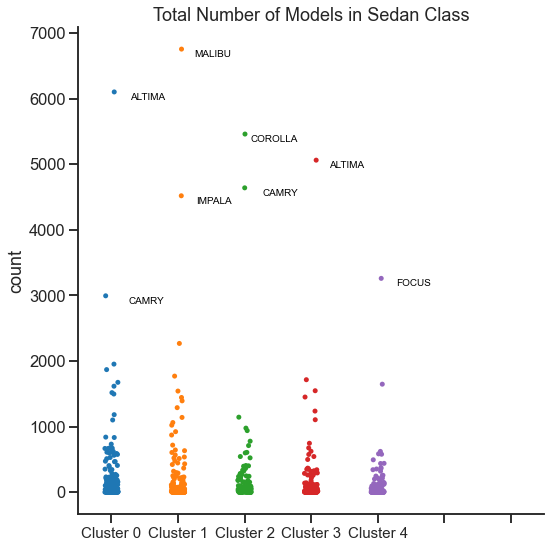

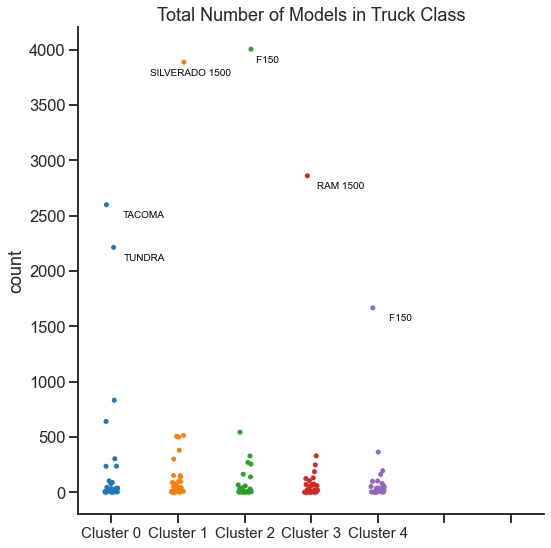

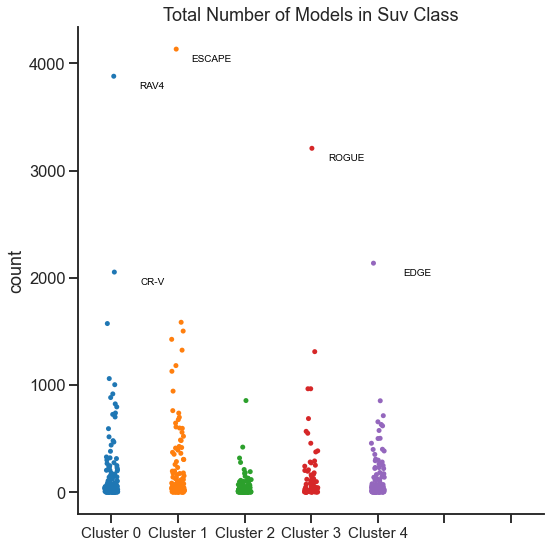

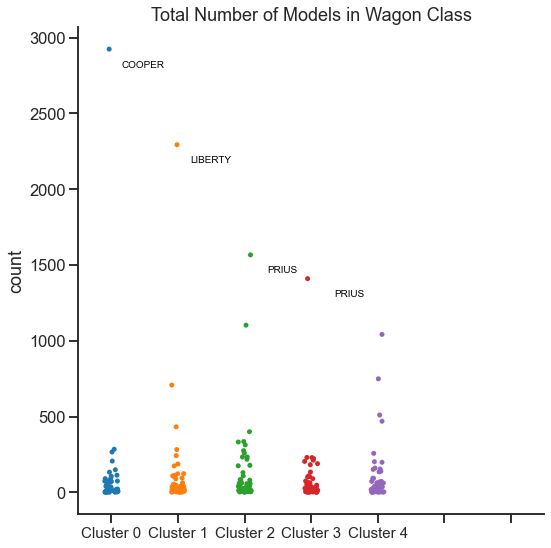

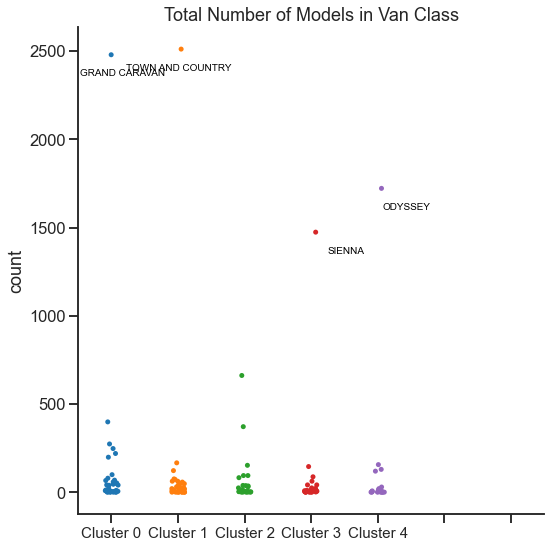

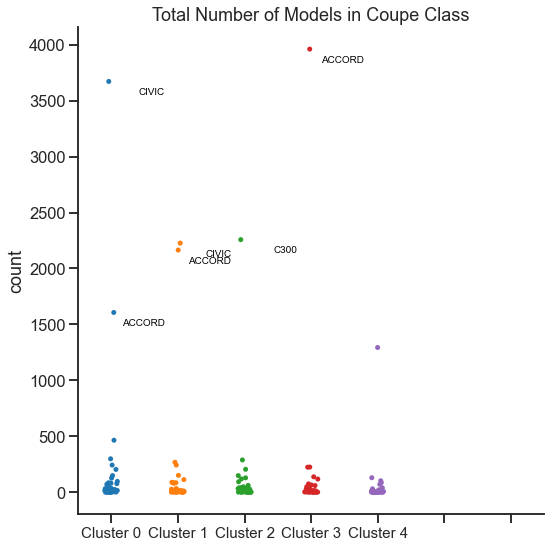

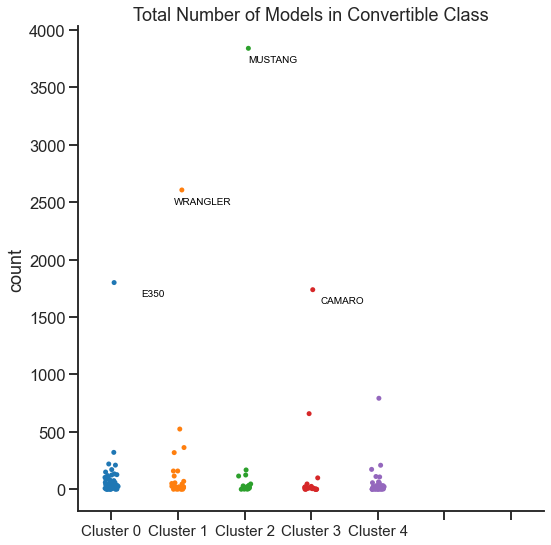

In [51]:
#sns.set_theme(style = "darkgrid")
#sns.set(rc={'axes.facecolor':'white'})

for index, car in enumerate(vehicle_classes):
    data = car.groupby(['purchase_make', 'purchase_model',
                        'cluster_label']).count().sort_values(by = 'cluster_label',ascending = False).reset_index()
    sns.set_style("ticks")
    sns.set_context("talk")

    p1 = sns.catplot(x = "cluster_label", y ='trade_in',order = [0,1,2,3,4,5,6], data = data,height = 8)
    for x, y, s in zip(data['cluster_label'], data['trade_in'],data['purchase_model']):
        if y > max(data['trade_in'])//2.5:
            if s == 'F150':
                s = s + '       '
            plt.text(x = x + .8, # x-coordinate position of data label
            y = y-120, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = s, # data label, formatted to ignore decimals
            color = 'black',
            fontsize = 10,
            horizontalalignment='right') # set colour of line)

    p1.set(title='Total Number of Models in {0} Class'.format(vehicle_classes_name[index].capitalize() ))
    p1.set_axis_labels("", "count").set_xticklabels(["Cluster 0", 'Cluster 1',"Cluster 2", 'Cluster 3',"Cluster 4"], fontsize = 15)
    p1.savefig(vehicle_classes_name[index]+"ClusterGroupings", dpi = 600)    
    #, 'Cluster 5',                                        'Cluster 6']

In [ ]:
for index, vehicle in enumerate(vehicle_classes):
    print("{0} is {1}% of total\n".format(vehicle_classes_name[index], len(vehicle)/len(carmax_df) * 100))

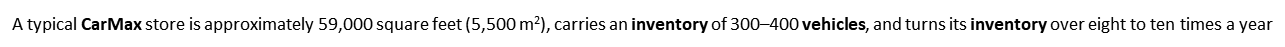

In [ ]:
for index, vehicle in enumerate(vehicle_classes):
    print("{0} is {1} of 400 vehichles \n".format(vehicle_classes_name[index], len(vehicle)/len(carmax_df) * 400))

In [ ]:
Distributions = {'sedan':170, 'truck':32,'suv':102, 'wagon':31, 'van':16, 'coupe':28, 'convertible':21}

Figure out he top 15 in each class

In [ ]:
sedan.purchase_model.value_counts()[:10]

In [ ]:
classDist = {}
for index, vehicle in enumerate(vehicle_classes):
    top10 = vehicle.purchase_model.value_counts()[:10]
    
    temp = {}
    for name, i in enumerate(top10):
        temp[top10.index[name]] = i/len(vehicle)
    
    classDist[vehicle_classes_name[index]] = temp

In [ ]:
sedan

In [ ]:
actualNums = {}
for classkey, dictvalue in classDist.items():
    temp = []
    for model,percent in dictvalue.items():
        temp.append((model,round(percent * Distributions[classkey])))
    
    actualNums[classkey] = temp

In [ ]:
x = 0
for i in actualNums.values():
    for j in i:
        x += j[1]

x

In [ ]:
actualNums

In [ ]:
classDist

In [ ]:
profile = ProfileReport(sedan[sedan.cluster_label == 1], title='Pandas Profiling Report', explorative=False)

In [ ]:
profile

In [ ]:
profile.to_file("your_report.html")

In [ ]:
ProfileReport(actualNums)

In [ ]:
cluster_df.subsequent_purchases.value_counts()

In [ ]:
sedan.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0]).to_html('test.html')